## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**U.S. Gridded Anthropogenic Methane Emissions Inventory**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/epa-ch4emission-yeargrid-v2express_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Contiguous United States
- **Spatial resolution**: 0.1° x 0.1°
- **Temporal extent**: 2012 - 2020
- **Temporal resolution**: Annual
- **Unit**: Megagrams of methane per square kilometer per year
- **Utility**: Climate Research

For more, visit the [U.S. Gridded Anthropogenic Methane Emissions Inventory](https://earth.gov/ghgcenter/data-catalog/epa-ch4emission-yeargrid-v2express) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the gridded methane emissions data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data
####  U.S. Gridded Anthropogenic Methane Emissions Inventory 

The gridded EPA U.S. anthropogenic methane greenhouse gas inventory (gridded GHGI) includes spatially disaggregated (0.1 deg x 0.1 deg or approximately 10 x 10 km resolution) maps of annual anthropogenic methane emissions (for the contiguous United States (CONUS)), consistent with national annual U.S. anthropogenic methane emissions reported in the U.S. EPA [Inventory of U.S. Greenhouse Gas Emissions and Sinks](https://www.epa.gov/ghgemissions/inventory-us-greenhouse-gas-emissions-and-sinks) (U.S. GHGI). 

This V2 Express Extension dataset contains methane emissions provided as fluxes, in units of molecules of methane per square cm per second, for over 25 individual emission source categories, including those from agriculture, petroleum and natural gas systems, coal mining, and waste. The data have been converted from their original NetCDF format to Cloud-Optimized GeoTIFF (COG) for use in the US GHG Center, thereby enabling user exploration of spatial anthropogenic methane emissions and their trends.

The gridded dataset currently includes 34 data layers. The first data layer includes annual 2012-2020 gridded methane emissions fluxes from all anthropogenic sources of methane in the U.S. GHGI (excluding Land Use, Land-Use Change and Forestry (LULUCF) sources, which are not included in the gridded GHGI). The next six data layers include annual 2012-2020 gridded methane fluxes from sources within the aggregate Agriculture, Natural Gas, Petroleum, Waste, Industry, and ‘Other’ source categories. The remaining 27 data layers include annual 2012-2020 gridded methane emissions fluxes from individual emission sectors within each of the aggregate categories.

For more information regarding this dataset, please visit the [U.S. Gridded Anthropogenic Methane Emissions Inventory](https://earth.gov/ghgcenter/data-catalog/epa-ch4emission-yeargrid-v2express) data overview page.

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes
- `item`:       One granule in the dataset, e.g. one monthly file of methane inverse fluxes
- `asset`:      A variable available within the granule, e.g. microbial, fossil, or pyrogenic methane fluxes
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching the data itself
- `Raster API`: Endpoint for fetching data **imagery**

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub, except the `tabulate` library. If you need to run this notebook elsewhere, please install the libraries by running the following command line:

%pip install requests folium rasterstats pystac_client pandas matplotlib tabulate --quiet

In [101]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import branca 
import pandas as pd
import matplotlib.pyplot as plt
#from tabulate import tabulate

## Query the STAC API

**STAC API Collection Names**

Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for the U.S. Gridded Anthropogenic Methane Emissions Inventory dataset is [**epa-ch4emission-yeargrid-v2express**](https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express)*

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [102]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes 
collection_name = "epa-ch4emission-yeargrid-v2express"


In [103]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac_client' library makes an HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=epa-ch4emission-yeargrid-v2express>

Next, you will examine the contents of the `collection` under the `temporal` variable. You’ll see that the data is available from January 2012 to December 2020. By looking at the `dashboard:time density`, you can observe that the periodic frequency of these observations is yearly.

In [104]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 9 items


This makes sense as there are 9 years between 2012 - 2020, meaning 9 records in total.  

In [105]:
# The search function allows us to look for data within a specific time range, e.g. 2012.
search = catalog.search(
    collections=collection_name,
    datetime=['2012-01-01T00:00:00Z','2012-12-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)

<Item id=epa-ch4emission-yeargrid-v2express-2012>


In [106]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=epa-ch4emission-yeargrid-v2express-2020>

# Creating Maps Using Folium

In this notebook, you will explore the impacts of methane emissions by examining changes over time in urban regions. You will visualize the outputs on a map using `folium`.

## Fetch Imagery from Raster API
Here we get information from the `Raster API` which we will add to our map in the next section.

In [107]:
# To access the year value from each item more easily, this will let us query more explicitly by year (e.g., 2020)
items = {item.properties["datetime"][:4]: item for item in collection.get_items()}

In [108]:
# Choose a colormap for displaying the tiles
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "spectral"

In [109]:
# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For this notebook, we'll work with “total-coal-mines". 
# You can read this field's description by browing the item_assets in the previous cell.
asset_name = "total-coal-mines"

In [110]:
# Specify two date/times that you would like to visualize, using the format of items_dict.keys()
dates = ['2018','2012']

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as the `rescale_values`, and will be passed to the Raster API in the following step(s).

In [111]:
# Extract collection name and item ID for the first date
observation_date_1 = items[dates[0]]
collection_id = observation_date_1.collection_id
item_id = observation_date_1.id
# Select relevant asset
object = observation_date_1.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print the raster bands' information
raster_bands

[{'scale': 1.0,
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float32',
  'histogram': {'max': 1642.84814453125,
   'min': -9999.0,
   'count': 11.0,
   'buckets': [243327.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1663.0, 10.0]},
  'statistics': {'mean': -9930.62109375,
   'stddev': 824.6806640625,
   'maximum': 1642.84814453125,
   'minimum': -9999.0,
   'valid_percent': 0.0004081632653061224}}]

In [112]:
# -9999.0 is the value for missing data, which mucks up our ability to use the mean or stddev for a colorbar range.
# Instead we'll just use the maximum value, and make the minimum colorbar value zero.
rescale_values = {
    "max": raster_bands[0]['statistics']['maximum'],
    "min": 0,
}

print(rescale_values)

{'max': 1642.84814453125, 'min': 0}


Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale values` to the Raster API endpoint. This step is done twice, one for each date/time you will visualize, and tells the Raster API which collection, item, and asset you want to view, specifying the colormap and colorbar ranges to use for visualization. The API returns a JSON with information about the requested image. Each image will be referred to as a tile.

In [113]:
# Make a GET request to retrieve information for the first date/time
observation_date_1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,20"
).json()

# Print the properties of the retrieved granule to the console
observation_date_1_tile


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/epa-ch4emission-yeargrid-v2express/items/epa-ch4emission-yeargrid-v2express-2018/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-coal-mines&color_formula=gamma+r+1.05&colormap_name=spectral&rescale=0%2C20'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

In [114]:
# Make a GET request to retrieve information for the second date/time
observation_date_2 = items[dates[1]]
# Extract collection name and item ID
collection_id = observation_date_2.collection_id
item_id = observation_date_2.id

observation_date_2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,20"
).json()

# Print the properties of the retrieved granule to the console
observation_date_2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/epa-ch4emission-yeargrid-v2express/items/epa-ch4emission-yeargrid-v2express-2012/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-coal-mines&color_formula=gamma+r+1.05&colormap_name=spectral&rescale=0%2C20'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

## Generate Map

In [115]:
# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(38.9, -80.0), zoom_start=6)

# Define the first map layer (January 2018)
map_layer_2018 = TileLayer(
    tiles=observation_date_1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    name='January 2018', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.7, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_2018.add_to(map_.m1)

# Define the second map layer (January 2012)
map_layer_2012 = TileLayer(
    tiles=observation_date_2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    name='January 2012', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.7, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_2012.add_to(map_.m2)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Visualize the Dual Map
map_

Observe from this that the southern end of the Appalachian Mountains saw somewhat of an increase in methane emissions from coal mines between 2012 and 2018.

# Calculate Zonal Statistics
To perform zonal statistics, we first need to create a polygon. In this use case, we've specified a polygon over the Pittsburgh, Pennsylvania region.

In [116]:
# Give the AOI a name to use in your plot title later on
aoi_name = "Pittsburgh, PA"
# Pittsburgh, PA, USA
aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-79.4, 39.9], # South-east bounding coordinate
                [-79.4, 40.9], # North-east bounding coordinate
                [-80.5, 40.9], # North-west bounding coordinate
                [-80.5, 39.9], # South-west bounding coordinate
                [-79.4, 39.9]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [117]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 9 items


In [118]:
# Examine the first item in the collection
items[0]

{'id': 'epa-ch4emission-yeargrid-v2express-2020',
 'bbox': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express/items/epa-ch4emission-yeargrid-v2express-2020'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/epa-ch4emission-yeargrid-v2express/items/epa-ch4emission-yeargrid-v2express-2020/map?assets=total-methane&maxzoom=5&minzoom=0&resca

Now that you created the polygon for the area of interest, you need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon. 

In [119]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it
# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

With the function above you can generate the statistics for the AOI.

In [120]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = {}
for item in items: 
    date = item["properties"]["datetime"]  # Get the associated date
    year = date[:4]  # Convert datetime to year
    stats[year] = generate_stats(item, aoi)

CPU times: user 29.4 ms, sys: 102 µs, total: 29.5 ms
Wall time: 1.9 s


In [121]:
# Print the stats for the observation of interest
# For example, for printing the stats for the 2016 tile, you can change the date inside the bracket "['YYYY']" to "['2016']
stats['2016']

{'statistics': {'b1': {'min': 3.2263499783992877e-15,
   'max': 1290.3424072265625,
   'mean': 36.09251403808594,
   'count': 70.0,
   'sum': 2526.47607421875,
   'std': 194.175369753092,
   'median': 2.5004677439710576e-08,
   'majority': 1.0761832099298943e-13,
   'minority': 3.2263499783992877e-15,
   'unique': 55.0,
   'histogram': [[68, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [3.2263499783992877e-15,
     129.03424072265625,
     258.0684814453125,
     387.10272216796875,
     516.136962890625,
     645.1712036132812,
     774.2054443359375,
     903.2396850585938,
     1032.27392578125,
     1161.30810546875,
     1290.3424072265625]],
   'valid_percent': 53.03,
   'masked_pixels': 62.0,
   'valid_pixels': 70.0,
   'percentile_2': 1.0754331791957596e-14,
   'percentile_98': 1029.9334716796875}},
 'datetime': '2016-01-01T00:00:00+00:00'}

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [122]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:
    pd.set_option('display.float_format', '{:.20f}'.format)
    stats_json_ = [stats_json[datetime] for datetime in stats_json]     
    # Normalize the JSON data
    df = pd.json_normalize(stats_json_)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,0.00000000000000073460,1312.80090332031250000000,36.88801574707031250000,69.00000000000000000000,2545.27319335937500000000,204.32702036196778294652,0.00000000005410499132,0.00000000005410499132,0.00000000000000073460,51.00000000000000000000,"[[67, 0, 0, 0, 0, 0, 0, 0, 1, 1], [7.345994349...",52.27000000000000312639,63.00000000000000000000,69.00000000000000000000,0.00000000000000244863,1117.67700195312500000000,2020-01-01 00:00:00+00:00
1,2019-01-01T00:00:00+00:00,0.00000000000000075290,1470.95764160156250000000,41.05800247192382812500,69.00000000000000000000,2833.00219726562500000000,228.25951513573318152339,0.00000000005545252799,0.00000000005545252799,0.00000000000000075290,51.00000000000000000000,"[[67, 0, 0, 0, 0, 0, 0, 0, 1, 1], [7.528953466...",52.27000000000000312639,63.00000000000000000000,69.00000000000000000000,0.00000000000000250961,1243.22229003906250000000,2019-01-01 00:00:00+00:00
2,2018-01-01T00:00:00+00:00,0.00000000000000078660,1642.84814453125000000000,45.81293487548828125000,69.00000000000000000000,3161.09252929687500000000,255.32128197870619601417,0.00000000005793516014,0.00000000005793516014,0.00000000000000078660,51.00000000000000000000,"[[67, 0, 0, 0, 0, 0, 0, 0, 1, 1], [7.866027580...",52.27000000000000312639,63.00000000000000000000,69.00000000000000000000,0.00000000000000262197,1393.42944335937500000000,2018-01-01 00:00:00+00:00
3,2017-01-01T00:00:00+00:00,0.00000000000000159273,1504.92590332031250000000,42.47336196899414062500,69.00000000000000000000,2930.66186523437500000000,234.00194477023049444142,0.00000000011730856564,0.00000000011730856564,0.00000000000000159273,52.00000000000000000000,"[[67, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1.592733013...",52.27000000000000312639,63.00000000000000000000,69.00000000000000000000,0.00000000000000530903,1278.66015625000000000000,2017-01-01 00:00:00+00:00
4,2016-01-01T00:00:00+00:00,0.00000000000000322635,1290.34240722656250000000,36.09251403808593750000,70.00000000000000000000,2526.47607421875000000000,194.17536975309201352502,0.00000002500467743971,0.00000000000010761832,0.00000000000000322635,55.00000000000000000000,"[[68, 0, 0, 0, 0, 0, 0, 1, 0, 1], [3.226349978...",53.03000000000000113687,62.00000000000000000000,70.00000000000000000000,0.00000000000001075433,1029.93347167968750000000,2016-01-01 00:00:00+00:00


## Time-Series Analysis
You can now explore the time series (January 2000 -December 2021) of your chosen `asset` for the specified `AOI`. You can plot the data set using the code below:

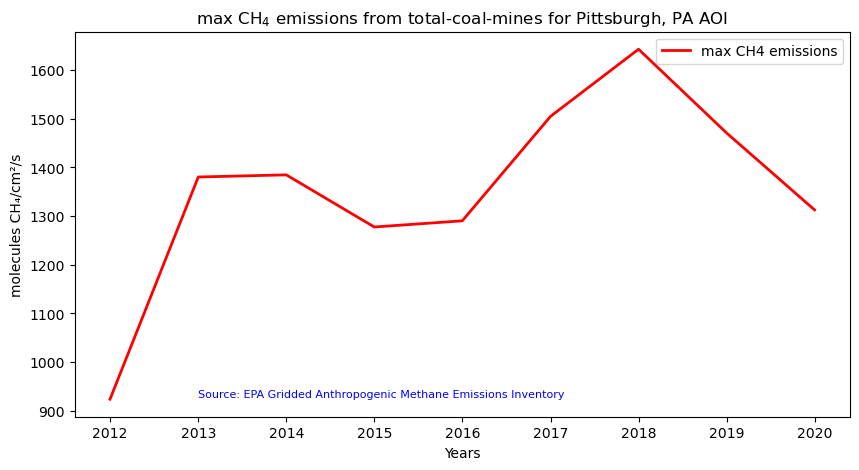

In [125]:
# Ensure 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort the DataFrame by the datetime column so the plot displays the values from left to right (2020 -> 2022)
df_sorted = df.sort_values(by="datetime")

# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(10, 5))

# Use which_stat to determine which value you would like to plot in the time series - min, max, mean etc.
which_stat = "max"

plt.plot(
    df["date"], # X-axis: sorted date
    df[which_stat],  # Y-axis: maximum CH4 emission
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=2, # Line width
    label=f"{which_stat} CH4 emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("molecules CH₄/cm²/s")

# Insert title for the plot
plt.title(f"{which_stat} CH$_4$ emissions from {asset_name} for {aoi_name} AOI")


# Add data citation
plt.text(
    df_sorted["datetime"].iloc[1],           # X-coordinate of the text 
    df_sorted[which_stat].min(),             # Y-coordinate of the text 

    # Text to be displayed
    "Source: EPA Gridded Anthropogenic Methane Emissions Inventory",                   
    fontsize=8,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="bottom",              # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the U.S. Gridded Anthropogenic Methane Emissions Inventory dataset:

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the anthropogenic methane emissions for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Generate a time-series graph of the anthropogenic methane emissions for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).